Data source

https://www.csc.kth.se/cvap/cvg/?page=footballdataset2

In [ ]:
!pip install opencv-python open3d numpy matplotlib

In [ ]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

In [ ]:
img1 = cv2.imread("img1.png")
img2 = cv2.imread("img2.png")
img3 = cv2.imread("img3.png")

In [ ]:
from torchvision import models
import torch

In [ ]:
# pose detection model
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.



KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
def get_keypoints(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img_rgb).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        output = model(img_tensor)

    keypoints = []
    for i in range(len(output[0]['keypoints'])):
        keypoints.append(output[0]['keypoints'][i].cpu().numpy())  # List of keypoints for all people

    return keypoints

# Get keypoints for all 3 images
keypoints1 = get_keypoints(img1)
keypoints2 = get_keypoints(img2)
keypoints3 = get_keypoints(img3)

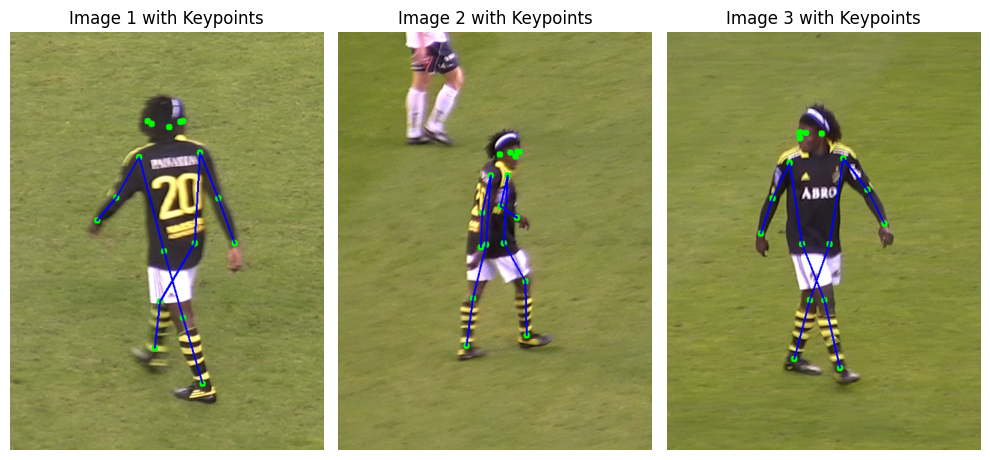

In [ ]:
def visualize_keypoints(img, keypoints, skeleton):
    img_copy = img.copy()

    for i, point in enumerate(keypoints):
        if not np.any(np.isnan(point)):
            cv2.circle(img_copy, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)  # Draw a green circle

    # Draw the skeleton
    for joint1, joint2 in skeleton:
        if not np.any(np.isnan(keypoints[joint1])) and not np.any(np.isnan(keypoints[joint2])):
            point1 = keypoints[joint1]
            point2 = keypoints[joint2]
            cv2.line(img_copy, (int(point1[0]), int(point1[1])), (int(point2[0]), int(point2[1])), (255, 0, 0), 2)  # Blue line

    return img_copy

skeleton = [
    (5, 7), (7, 9),   # Right arm
    (6, 8), (8, 10),  # Left arm
    (5, 11), (6, 12), # Torso sides
    (11, 13), (13, 15), # Right leg
    (12, 14), (14, 16)  # Left leg
]

img1_with_keypoints = visualize_keypoints(img1, keypoints1[0], skeleton)
img2_with_keypoints = visualize_keypoints(img2, keypoints2[0], skeleton)
img3_with_keypoints = visualize_keypoints(img3, keypoints3[0], skeleton)


plt.figure(figsize=(10, 10))

# Plot for img1
plt.subplot(131)
plt.imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

# Plot for img2
plt.subplot(132)
plt.imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

# Plot for img3
plt.subplot(133)
plt.imshow(cv2.cvtColor(img3_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 3 with Keypoints')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
import numpy as np
import plotly.graph_objects as go

def plot_3d_pose_interactive(points_3d, skeleton, joint_names):
    fig = go.Figure()

    # Plot skeleton connections
    for i, j in skeleton:
        if not np.any(np.isnan(points_3d[i])) and not np.any(np.isnan(points_3d[j])):
            x = [points_3d[i][0], points_3d[j][0]]
            y = [points_3d[i][1], points_3d[j][1]]
            z = [points_3d[i][2], points_3d[j][2]]
            fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='red', width=2)))

    # Plot joints
    for idx, point in enumerate(points_3d):
        if not np.any(np.isnan(point)):
            fig.add_trace(go.Scatter3d(
                x=[point[0]], y=[point[1]], z=[point[2]],
                mode='markers+text',
                marker=dict(color='blue', size=6),
                text=[joint_names[idx]] if joint_names else [""],
                textposition="top center",
                showlegend=False
            ))

    # Plot the 3D points
    x_points = [point[0] for point in points_3d if not np.any(np.isnan(point))]
    y_points = [point[1] for point in points_3d if not np.any(np.isnan(point))]
    z_points = [point[2] for point in points_3d if not np.any(np.isnan(point))]

    fig.add_trace(go.Scatter3d(x=x_points, y=y_points, z=z_points,
                               mode='markers', marker=dict(color='blue', size=5)))

    fig.update_layout(
        title='3D Pose Reconstruction',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(r=10, l=10, b=10, t=40)
    )

    fig.show()

# find fundamental matrix since K, R, and t are unknown
pts1 = keypoints1[0][:, :2]
pts2 = keypoints2[0][:, :2]
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
U, S, Vt = np.linalg.svd(F.T)
e2 = Vt[-1]
e2 = e2 / e2[2]

# Skew-symmetric matrix of epipole
def skew(x):
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])

# Second camera matrix (up to scale)
P2 = np.hstack((skew(e2) @ F, e2.reshape(3, 1))) # Second camera: R and t from pose

# Triangulate 3D points
pts4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points3D = (pts4D[:3] / pts4D[3]).T


skeleton = [
    (5, 7), (7, 9),   # Right arm
    (6, 8), (8, 10),  # Left arm
    (5, 11), (6, 12), # Torso sides
    (11, 13), (13, 15), # Right leg
    (12, 14), (14, 16),  # Left leg
    (11, 12), (5, 6)
]
joint_names = [
    "Nose", "Eye L", "Eye R", "Ear L", "Ear R",
    "Shoulder R", "Shoulder L", "Elbow R", "Elbow L", "Wrist R", "Wrist L",
    "Hip R", "Hip L", "Knee R", "Knee L", "Ankle R", "Ankle L"
]
# Plot the reconstructed 3D pose
plot_3d_pose_interactive(points3D, skeleton, joint_names)